# Datascience Project

## About
The project is about which of the cities(Paris, Toronto and NYC(Manhattan)) are similar to each other

## Implementation

We use venues related data for neighbourhoods in the cities using foursquare api and use the top venue data to cluster the neighbourhoods into groups.


## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from IPython.display import Image
from IPython.core.display import HTML
from pandas.io.json import json_normalize
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json

In [2]:
!conda install lxml --yes


!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim


!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB
    certifi-2019.6.16          |           py36_1         156 KB
    lxml-4.3.0                 |   py36hefd8a0e_0         1.5 MB
    ------------------------------------------------------------
                                           Total:         4.8 MB

The following packages will be UPDATED:

    certifi: 2019.6.16-py36_1     conda-forge --> 2019.6.16-py36_1    
    lxml:    4.2.5-py37hefd8a0e_0             --> 4.3.0-py36hefd8a0e_0
    openssl: 1.0.2

## Preparing databases for analysis

## Creating database for toronto

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [4]:
tables = pd.read_html(url, header =0)

In [5]:
df_toronto_initial = tables[0]
df_toronto_initial.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [6]:
df_toronto_initial = df_toronto_initial[df_toronto_initial.Borough != 'Not assigned']

In [7]:
df_toronto_initial_copy = df_toronto_initial

In [8]:
df_toronto_pivot = df_toronto_initial_copy.pivot_table( index = ['Postcode','Borough'], values = 'Neighbourhood', aggfunc=','.join )
df_toronto_pivot.reset_index(inplace = True)
df_toronto_pivot.head()



,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
for count, i in enumerate(df_toronto_pivot['Neighbourhood']):
    if(i=="Not assigned"):
        df_toronto_pivot.loc[count]["Neighbourhood"] = df_toronto_pivot.loc[count]["Borough"]

## Getting Latitudes and Longitudes for toronto neighbourhood

In [10]:
url_toronto_cood = 'https://cocl.us/Geospatial_data'
df_toronto_Cood = pd.read_csv(url_toronto_cood)
df_toronto_Cood.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df_toronto_merged = pd.merge(df_toronto_pivot, df_toronto_Cood, left_on = ['Postcode'], right_on=['Postal Code'], how = 'left')
df_toronto_merged.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [12]:
df_toronto_merged.drop(columns= ['Postal Code'])
df_toronto_merged.shape

(103, 6)

## Using only borough with toronto in name

In [13]:
toronto = df_toronto_merged[df_toronto_merged["Borough"].str.contains("Toronto")]

In [14]:
toronto = toronto.reset_index().drop(columns=["index"])

In [15]:
toronto = toronto[['Postal Code','Borough', 'Neighbourhood',  'Latitude','Longitude']]


In [16]:
toronto["City"] ="Toronto"
toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,City
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Toronto
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Toronto
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,Toronto
3,M4M,East Toronto,Studio District,43.659526,-79.340923,Toronto
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Toronto


In [17]:
toronto.drop(columns=["Borough","Postal Code"],inplace=True)
toronto.head()

,Neighbourhood,Latitude,Longitude,City
0,The Beaches,43.676357,-79.293031,Toronto
1,"The Danforth West,Riverdale",43.679557,-79.352188,Toronto
2,"The Beaches West,India Bazaar",43.668999,-79.315572,Toronto
3,Studio District,43.659526,-79.340923,Toronto
4,Lawrence Park,43.728020,-79.388790,Toronto


## Creating database for Paris

In [18]:
df_paris = pd.read_html("https://en.wikipedia.org/wiki/Arrondissements_of_Paris")

In [19]:
df__paris_neighbourhood = df_paris[2]

In [20]:
df__paris_neighbourhood.drop(df__paris_neighbourhood.columns[2:], axis=1, inplace=True)

In [21]:
df__paris_neighbourhood

,"Arrondissement (R for Right Bank, L for Left Bank)",Name
0,1st (Ie) R,Louvre
1,2nd (IIe) R,Bourse
2,3rd (IIIe) R,Temple
3,4th (IVe) R,Hôtel-de-Ville
4,5th (Ve) L,Panthéon
5,6th (VIe) L,Luxembourg
6,7th (VIIe) L,Palais-Bourbon
7,8th (VIIIe) R,Élysée
8,9th (IXe) R,Opéra
9,10th (Xe) R,Entrepôt


In [22]:
df__paris_neighbourhood["Latitude"] = ""
df__paris_neighbourhood["Longitude"] = ""

## Finding Latitudes and Longitudes for neighbourhood in Paris using geocode

In [23]:
def landl(address):
    geolocator = Nominatim(user_agent = 'city_explorer')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [24]:
for count,i in enumerate(df__paris_neighbourhood.iloc[:,3]):
    
    address =i + ",Paris"

    df__paris_neighbourhood["Latitude"][count],df__paris_neighbourhood["Longitude"][count] = landl(address) 

In [25]:
df__paris_neighbourhood["City"] = "Paris"

In [26]:
df__paris_neighbourhood.head()

,"Arrondissement (R for Right Bank, L for Left Bank)",Name,Latitude,Longitude,City
0,1st (Ie) R,Louvre,48.8566,2.3515,Paris
1,2nd (IIe) R,Bourse,48.8566,2.3515,Paris
2,3rd (IIIe) R,Temple,48.8566,2.3515,Paris
3,4th (IVe) R,Hôtel-de-Ville,48.8566,2.3515,Paris
4,5th (Ve) L,Panthéon,48.8566,2.3515,Paris


In [27]:
df__paris_neighbourhood.rename(columns = {"Name":"Neighbourhood"})

,"Arrondissement (R for Right Bank, L for Left Bank)",Neighbourhood,Latitude,Longitude,City
0,1st (Ie) R,Louvre,48.8566,2.3515,Paris
1,2nd (IIe) R,Bourse,48.8566,2.3515,Paris
2,3rd (IIIe) R,Temple,48.8566,2.3515,Paris
3,4th (IVe) R,Hôtel-de-Ville,48.8566,2.3515,Paris
4,5th (Ve) L,Panthéon,48.8566,2.3515,Paris
5,6th (VIe) L,Luxembourg,48.8566,2.3515,Paris
6,7th (VIIe) L,Palais-Bourbon,48.8566,2.3515,Paris
7,8th (VIIIe) R,Élysée,48.8566,2.3515,Paris
8,9th (IXe) R,Opéra,48.8566,2.3515,Paris
9,10th (Xe) R,Entrepôt,48.8566,2.3515,Paris


In [28]:
paris = df__paris_neighbourhood.drop(["Arrondissement (R for Right Bank, L for Left Bank)"], axis=1)

In [29]:
paris.rename(columns={"Name":"Neighbourhood"}, inplace= True)
paris.head()

,Neighbourhood,Latitude,Longitude,City
0,Louvre,48.8566,2.3515,Paris
1,Bourse,48.8566,2.3515,Paris
2,Temple,48.8566,2.3515,Paris
3,Hôtel-de-Ville,48.8566,2.3515,Paris
4,Panthéon,48.8566,2.3515,Paris


## Getting database for New York

In [30]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [31]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [32]:
neighbourhoods_data = newyork_data['features']

In [33]:
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
neighbourhoods = pd.DataFrame(columns=column_names)

In [34]:
for data in neighbourhoods_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

## Getting Boroughs for only Manhattan

In [35]:
manhattan_data = neighbourhoods[neighbourhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [36]:
manhattan_data.drop(columns=["Borough"], inplace =True)

In [37]:
manhattan_data["City"]= "NYC"

In [38]:
manhattan_data.head()

,Neighbourhood,Latitude,Longitude,City
0,Marble Hill,40.876551,-73.910660,NYC
1,Chinatown,40.715618,-73.994279,NYC
2,Washington Heights,40.851903,-73.936900,NYC
3,Inwood,40.867684,-73.921210,NYC
4,Hamilton Heights,40.823604,-73.949688,NYC


## Merging databases for Paris, Toronto and Manhattan Data

In [39]:
final_df = toronto.append(paris, ignore_index=True)

In [40]:
final_df=final_df.append(manhattan_data, ignore_index=True)

In [41]:
final_df.tail()

,Neighbourhood,Latitude,Longitude,City
93,Turtle Bay,40.752,-73.9677,NYC
94,Tudor City,40.7469,-73.9712,NYC
95,Stuyvesant Town,40.731,-73.9741,NYC
96,Flatiron,40.7397,-73.9909,NYC
97,Hudson Yards,40.7567,-74.0001,NYC


## Using foursquare to explore venues in the three cities

In [42]:
"""Foursquare Credentials"""

CLIENT_ID = 'MDBOQP5WLJKBGYX3O0SYR2CWUUHFYFLASPLK1GLQWEC3UVPS'
CLIENT_SECRET = 'U0SUGW3XIQRXB3FETTUJSTVLMSZ4GT1XPUUG0UNGDLKJVRT5'
VERSION = '20180605'


In [43]:
LIMIT =10
def explore(names, latitudes, longitudes, city, radius=500):
    
    venues_list=[]
    for name, lat, lng, city in zip(names, latitudes, longitudes, city):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
   
         
        venues_list.append([(
            name, 
            lat, 
            lng,
            city,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v["venue"]["categories"][0]['icon']['prefix']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude',
                  'city',           
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Primary']
    
    return(nearby_venues)

In [44]:
city_venues= explore(names = final_df["Neighbourhood"],
                        latitudes = final_df["Latitude"],
                        longitudes = final_df["Longitude"],
                    city=final_df["City"])

In [45]:
city_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,city,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Primary
0,The Beaches,43.676357,-79.293031,Toronto,Glen Manor Ravine,43.676821,-79.293942,Trail,https://ss3.4sqi.net/img/categories_v2/parks_o...
1,The Beaches,43.676357,-79.293031,Toronto,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,https://ss3.4sqi.net/img/categories_v2/shops/f...
2,The Beaches,43.676357,-79.293031,Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub,https://ss3.4sqi.net/img/categories_v2/nightli...
3,The Beaches,43.676357,-79.293031,Toronto,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,https://ss3.4sqi.net/img/categories_v2/parks_o...
4,The Beaches,43.676357,-79.293031,Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood,https://ss3.4sqi.net/img/categories_v2/parks_o...


## Finding Primary Category for Venues 

In [46]:
for y, i in enumerate(city_venues["Venue Primary"]):
    city_venues["Venue Primary"][y] = i.split("/")[5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
city_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,city,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Primary
0,The Beaches,43.676357,-79.293031,Toronto,Glen Manor Ravine,43.676821,-79.293942,Trail,parks_outdoors
1,The Beaches,43.676357,-79.293031,Toronto,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,shops
2,The Beaches,43.676357,-79.293031,Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub,nightlife
3,The Beaches,43.676357,-79.293031,Toronto,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,parks_outdoors
4,The Beaches,43.676357,-79.293031,Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood,parks_outdoors


In [48]:
city_primary_venue = city_venues[["Neighbourhood","Venue Primary","Venue Category"]]


## Finding count of venues in Neighbourhood

In [49]:
city_primary_venue.groupby(["Neighbourhood","Venue Primary"]).count()


Venue Category
Neighbourhood          Venue Primary                     
Adelaide,King,Richmond arts_entertainment               1
                       food                             5
                       nightlife                        1
                       parks_outdoors                   1
                       shops                            1
...                                                   ...
Yorkville              shops                            3
Élysée                 arts_entertainment               1
                       food                             3
                       parks_outdoors                   4
                       shops                            2

[360 rows x 1 columns]

## Hot Encoding the primary categories

In [50]:
city_venue_onehot_encoding = pd.get_dummies(city_venues[['Venue Primary']], prefix="", prefix_sep="")
city_venue_onehot_encoding['Neighbourhood'] = city_venues['Neighbourhood']
city_venue_onehot_encoding['city'] = city_venues['city']
fixed_columns = [city_venue_onehot_encoding.columns[-1]] + list(city_venue_onehot_encoding.columns[:-1])
city_venue_onehot_encoding = city_venue_onehot_encoding[fixed_columns]

In [51]:
city_venue_onehot_encoding

,city,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,Neighbourhood
0,Toronto,0,0,0,0,1,0,0,The Beaches
1,Toronto,0,0,0,0,0,1,0,The Beaches
2,Toronto,0,0,0,1,0,0,0,The Beaches
3,Toronto,0,0,0,0,1,0,0,The Beaches
4,Toronto,0,0,0,0,1,0,0,The Beaches
5,Toronto,0,0,1,0,0,0,0,"The Danforth West,Riverdale"
6,Toronto,0,0,1,0,0,0,0,"The Danforth West,Riverdale"
7,Toronto,0,0,0,0,0,1,0,"The Danforth West,Riverdale"
8,Toronto,0,0,1,0,0,0,0,"The Danforth West,Riverdale"
9,Toronto,0,0,1,0,0,0,0,"The Danforth West,Riverdale"


In [52]:
city_venue_grouped = city_venue_onehot_encoding.groupby(['Neighbourhood','city']).mean().reset_index()


## Using Clustering to find the which cities are similar

In [53]:
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit_predict(city_venue_grouped.iloc[:,2:9])


In [54]:
kmeans.shape

(98,)

In [55]:
city_venue_grouped["cluster"] = kmeans

In [56]:
city_venue_grouped.head()

,Neighbourhood,city,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,cluster
0,"Adelaide,King,Richmond",Toronto,0.1,0.0,0.5,0.1,0.1,0.1,0.1,0
1,Batignolles-Monceau,Paris,0.1,0.0,0.3,0.0,0.4,0.2,0.0,1
2,Battery Park City,NYC,0.0,0.1,0.3,0.0,0.2,0.4,0.0,1
3,Berczy Park,Toronto,0.2,0.0,0.4,0.1,0.1,0.2,0.0,0
4,Bourse,Paris,0.1,0.0,0.3,0.0,0.4,0.2,0.0,1


In [57]:
total_city_counts = city_venue_grouped["city"].value_counts()

In [58]:
cluster1 = city_venue_grouped.loc[city_venue_grouped["cluster"]==0]

In [59]:
cluster2 = city_venue_grouped.loc[city_venue_grouped["cluster"]==1]

## Counts of each city in the clusters

In [60]:
cluster1.groupby("city").count()

,Neighbourhood,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,cluster
city,,,,,,,,,
NYC,31,31,31,31,31,31,31,31,31
Toronto,29,29,29,29,29,29,29,29,29


In [61]:
cluster2.groupby("city").count()

,Neighbourhood,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,cluster
city,,,,,,,,,
NYC,9,9,9,9,9,9,9,9,9
Paris,20,20,20,20,20,20,20,20,20
Toronto,9,9,9,9,9,9,9,9,9


In [62]:
y_city1=cluster1["city"].value_counts()
y_city2=cluster2["city"].value_counts()

In [63]:
index_city1 = y_city1.index
index_city2 = y_city2.index

for i in  index_city1:
    y_city1_val =y_city1[index_city1]
    #print(y_city1_val)
    
for i in index_city2:    
    y_city2_val =y_city2[index_city2]
    
y_city1_val[y_city1_val.index] = y_city1_val[y_city1_val.index]/total_city_counts[y_city1_val.index]
y_city2_val[y_city2_val.index] = y_city2_val[y_city2_val.index]/total_city_counts[y_city2_val.index]

## Bar Plot for easy understanding of which cities are similar based on venues in Neighbourhood

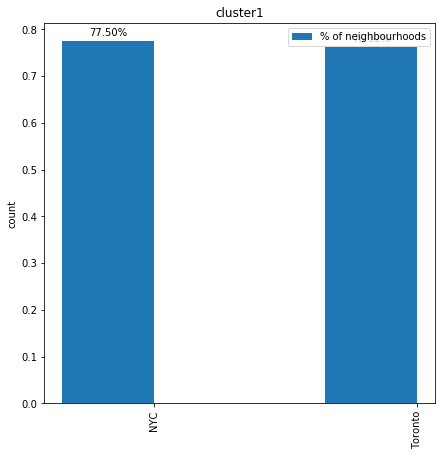

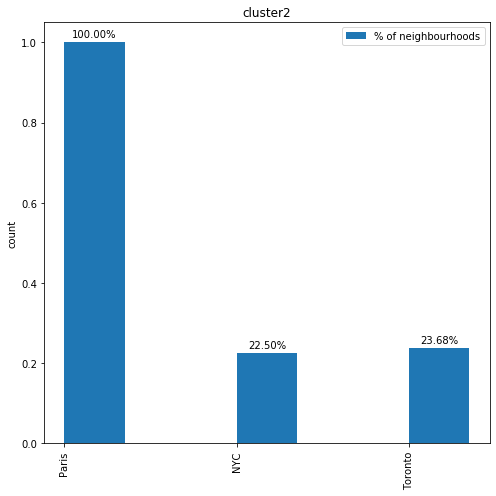

In [64]:
x1 = np.arange(len(index_city1))
x2 = np.arange(len(index_city2))

width = 0.35

fig, ax1 = plt.subplots(figsize=(7,7))
fig, ax2 = plt.subplots(figsize=(7,7))

rects1 = ax1.bar(x1 - width/2, y_city1_val, width, label='% of neighbourhoods')


ax1.set_ylabel('count')
ax1.set_title('cluster1')
ax1.set_xticks(x1)
ax1.set_xticklabels(index_city1, rotation="vertical")
ax1.legend()



rects2 = ax2.bar(x2 + width/2, y_city2_val, width, label='% of neighbourhoods')
ax2.set_ylabel('count')
ax2.set_title('cluster2')
ax2.set_xticks(x2)
ax2.set_xticklabels(index_city2, rotation="vertical")
ax2.legend()


def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}%'.format(height*100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

        
        


autolabel(rects1,ax1)
autolabel(rects2,ax2)



fig.tight_layout()

plt.show()


## As seen above Paris in completely in cluster2 

## Manhattan(NYC) and Toronto neighbourhoods are mostly in cluster1

## Toronto and NYC are more similar to each other than to paris

In [65]:
merged = pd.merge(city_primary_venue,city_venue_grouped[["cluster","Neighbourhood"]], left_on ="Neighbourhood",right_on ="Neighbourhood", how ="left")

In [66]:
cluster_analysis = merged[["cluster","Venue Primary","Venue Category"]]

In [67]:
cluster_analysis.head()

,cluster,Venue Primary,Venue Category
0,1,parks_outdoors,Trail
1,1,shops,Health Food Store
2,1,nightlife,Pub
3,1,parks_outdoors,Other Great Outdoors
4,1,parks_outdoors,Neighborhood


In [68]:
cluster_analysis_groupby = cluster_analysis.groupby(["cluster","Venue Primary"]).count()

In [69]:
cluster_analysis_groupby

Venue Category
cluster Venue Primary                     
0       arts_entertainment              30
        building                        32
        food                           364
        nightlife                       44
        parks_outdoors                  26
        shops                           92
        travel                          12
1       arts_entertainment              34
        building                        16
        food                            88
        nightlife                        7
        parks_outdoors                 115
        shops                           74
        travel                           8

In [70]:
cluster_analysis_unstack = cluster_analysis_groupby.unstack()

## Cluster analysis and breakdown of what venues are important for each cluster

In [71]:
cluster_analysis_unstack

Venue Category                                               \
Venue Primary arts_entertainment building food nightlife parks_outdoors shops   
cluster                                                                         
0                             30       32  364        44             26    92   
1                             34       16   88         7            115    74   

                      
Venue Primary travel  
cluster               
0                 12  
1                  8

In [72]:
cluster_one = pd.DataFrame(cluster_analysis_unstack.iloc[0])
cluster_one_total = cluster_one.sum()
cluster_two = pd.DataFrame(cluster_analysis_unstack.iloc[1])
cluster_two_total = cluster_two.sum()

In [73]:
cluster_one.rename(columns={0:"count"})
cluster_two.rename(columns={0:"count"})


1
               Venue Primary          
Venue Category arts_entertainment   34
               building             16
               food                 88
               nightlife             7
               parks_outdoors      115
               shops                74
               travel                8

In [74]:
x_axis_one = cluster_one.index
y_axis_one = cluster_one.iloc[:,0]

In [75]:
x_axis_two = cluster_two.index
y_axis_two = cluster_two.iloc[:,0]

In [76]:

cluster_one_values = cluster_one.iloc[:,0]
cluster_two_values = cluster_two.iloc[:,0]



In [111]:

width = 0.35

In [78]:
cluster_one.index = cluster_one.index.droplevel(0)


In [79]:
labels = cluster_one.index

In [80]:

yforcluster1=cluster_one_values/cluster_one_values.sum()*100
yforcluster2=cluster_two_values/cluster_two_values.sum()*100


In [112]:
x = np.arange(len(labels))

In [113]:
x

array([0, 1, 2, 3, 4, 5, 6])

## Bar Plot for understanding clustering

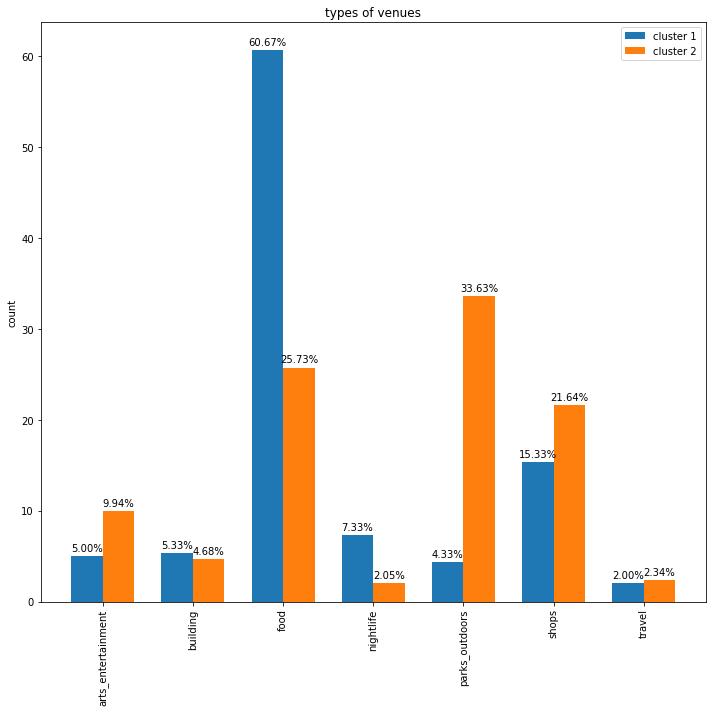

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, yforcluster1, width, label='cluster 1')
rects2 = ax.bar(x + width/2, yforcluster2, width, label='cluster 2')


ax.set_ylabel('count')
ax.set_title('types of venues')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation="vertical")
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



autolabel(rects1)
autolabel(rects2)



fig.tight_layout()

plt.show()


## It seems that cluster 1 has high number of venues related to food.

## About 61% of top venues in neighbourhoods in cluster1 are related to food and 15% related to shopping which makes bulk of all venues

## It seems that cluster 2 has high number of venues related to parks and outdoor venues.

## About 34% of top venues in neighbourhoods in cluster2 are related to parks and outdoor venues while food are about 26% followed by shops at about 21%